# Electron Photon tagging

This is a first test to implement a QAE and compare it to a classical AE.  
The task is to identify Electrons and Photons from em-calorimeter images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp


import warnings
warnings.filterwarnings('ignore')

2022-06-30 23:09:56.592131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-30 23:09:56.592321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-30 23:10:02.217100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-30 23:10:02.217148: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-30 23:10:02.217179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-06-30 23:10:02.217639: I tensorflow/core/platform/cpu_fe

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (60000, 28, 28)
x_test:  (10000, 28, 28)
y_train:  (60000,)
y_test:  (10000,)


Train on 6s and 3s

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


# Dimensionality reduction

To use the QAE we need to reduce the dimension as only a couple of qbits are available.
The easiest way is a simple PCA.

In [4]:
DOWNSCALE = 2
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)

In [5]:
x_train_threes = x_train[y_train==True]
x_train = x_train[y_train==False]

x_test_threes = x_test[y_test==True]
x_test = x_test[y_test==False]

In [6]:
x_train_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_train]
x_test_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_test]

x_train_circuit_threes = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_train_threes]
x_test_circuit_threes = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_test_threes]

In [7]:
x_train_tf = tfq.convert_to_tensor(x_train_circuit)
x_test_tf = tfq.convert_to_tensor(x_test_circuit)

x_train_tf_threes = tfq.convert_to_tensor(x_train_circuit_threes)
x_test_tf_threes = tfq.convert_to_tensor(x_test_circuit_threes)

In [8]:
from hep_VQAE import QAE as qae

model = qae.SQAE_model(4,LATENT_BITS,5)

Train with mse

In [9]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.1))

In [10]:
y_train_ones = np.ones(shape=len(x_train_tf))
y_test_ones = np.ones(shape=len(x_test_tf))

y_train_ones_threes = np.ones(shape=len(x_train_tf_threes))
y_test_ones_threes = np.ones(shape=len(x_test_tf_threes))

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
history = model.fit(x_train_tf, y_train_ones, epochs=50, batch_size=64, validation_data=(x_test_tf, y_test_ones), callbacks=[es])

Epoch 1/50
93/93 [==============================] - 34s 344ms/step - loss: 0.0772 - val_loss: 0.0276
Epoch 2/50
93/93 [==============================] - 32s 346ms/step - loss: 0.0269 - val_loss: 0.0259
Epoch 3/50
93/93 [==============================] - 31s 330ms/step - loss: 0.0137 - val_loss: 0.0119
Epoch 4/50
93/93 [==============================] - 30s 315ms/step - loss: 0.0109 - val_loss: 0.0116
Epoch 5/50
93/93 [==============================] - 31s 333ms/step - loss: 0.0111 - val_loss: 0.0118
Epoch 6/50
93/93 [==============================] - 29s 316ms/step - loss: 0.0106 - val_loss: 0.0117
Epoch 7/50
93/93 [==============================] - 30s 320ms/step - loss: 0.0106 - val_loss: 0.0117
Epoch 8/50
93/93 [==============================] - 30s 327ms/step - loss: 0.0108 - val_loss: 0.0119
Epoch 9/50
93/93 [==============================] - 30s 324ms/step - loss: 0.0108 - val_loss: 0.0118
Epoch 10/50
93/93 [==============================] - 33s 363ms/step - loss: 0.0105 - val_lo

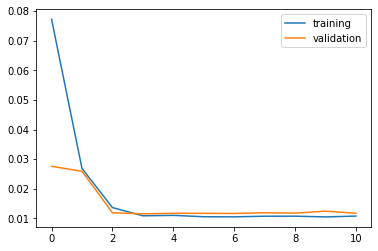

In [16]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
#plt.yscale('log')
plt.legend()

In [17]:
pred_six = model.predict(x_test_tf)
print("Median six reconstruciton fidelities: ",np.median(pred_six))

pred_three = model.predict(x_test_tf_threes)
print("Median three reconstruciton fidelities: ", np.median(pred_three))

Median six reconstruciton fidelities:  0.92980254
Median three reconstruciton fidelities:  0.5332107


(array([ 37., 110., 182., 235., 219., 129.,  60.,  25.,  11.,   2.]),
 array([0.24985838, 0.32469445, 0.39953053, 0.4743666 , 0.5492027 ,
        0.62403876, 0.69887483, 0.7737109 , 0.848547  , 0.92338306,
        0.99821913], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7fb62bf5e0a0>])

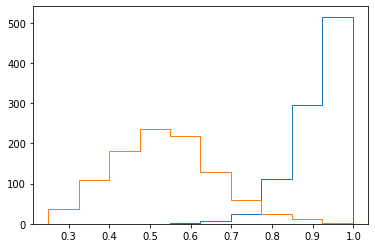

In [18]:
bins = np.histogram(np.hstack((pred_six.reshape((pred_six.shape[0],)), pred_three.reshape((pred_three.shape[0],)))), bins=10)[1]
plt.hist(pred_six, histtype='step', label="sixes",bins=bins)
plt.hist(pred_three, histtype='step', label="threes",bins=bins)

0.9634146341463414


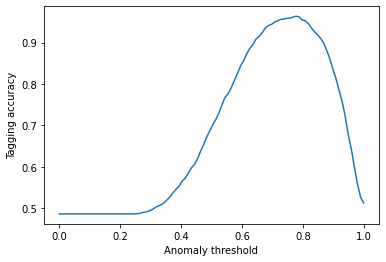

In [19]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_six > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_three < T)
    acc = (num_six_right + num_three_right)/(len(pred_six) + len(pred_three))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.ylabel("Tagging accuracy")
plt.xlabel("Anomaly threshold")
plt.plot(Ts, accs)  